In [1]:
import os
import sys 
import cv2
sys.path.append('..')
import pandas as pd  
import numpy as np
from PIL import Image
from wildlife_datasets import analysis, datasets, loader
from wildlife_datasets import datasets, splits
from wildlife_datasets.analysis import display_statistics
from wildlife_datasets.splits import visualize_split
from wildlife_datasets.splits import TimeCutoffSplit, TimeProportionSplit

Setting up the dataset 

In [2]:
d = datasets.SeaTurtleIDHeads('SeaTurtleIDHeads')##root ='SeaTurtleIDHeads'

      image_id identity                        path        date orientation
0            0     t281  images\t281\ILXxnZwvNh.JPG  2016-07-11     topleft
1            1     t281  images\t281\DjtwgIIURL.JPG  2016-07-11       right
2            2     t281  images\t281\hHfmOdhzDU.JPG  2016-07-11     topleft
3            3     t281  images\t281\gTovpgwOut.JPG  2016-07-11        left
4            4     t281  images\t281\yUETlrBYAp.JPG  2016-07-11       right
...        ...      ...                         ...         ...         ...
7577      7769     t157  images\t157\onmATVzAyB.JPG  2015-06-30     topleft
7578      7770     t157  images\t157\FQNPajeBYd.JPG  2015-06-30    topright
7579      7771     t157  images\t157\cwXNsIVEFz.JPG  2015-06-30         top
7580      7772     t157  images\t157\blzCVWUqSI.JPG  2015-06-30       right
7581      7773     t157  images\t157\GlAcIiUGqN.JPG  2015-06-30    topright

[7582 rows x 5 columns]
Number of identitites            400
Number of all animals     

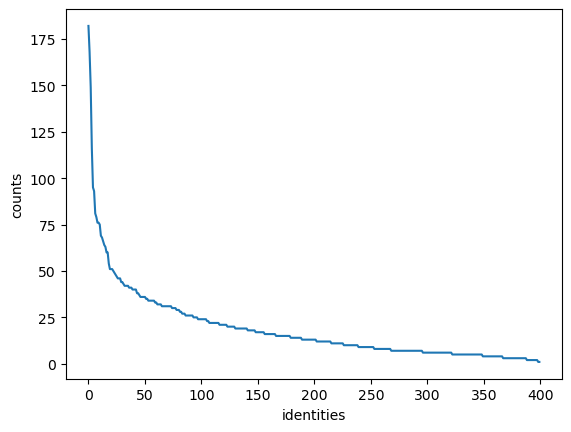

In [3]:
x=d.df #To look at the data. 
print(x) 
#Printing the anaylsis of the dataset 
print(analysis.display_statistics(x))

In [4]:
import numpy as np 
import torch  
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor 
from torch.utils.data import DataLoader

In [5]:
#Only getting the data for the right orientation 
x = x.loc[(x['orientation'] == 'left') | (x['orientation'] == 'topleft')]

#Selecting a ten turtles only 
x=x[x['identity'].isin(['t023','t025','t033','t034','t073','t094','t204','t217','t243','t323'])] 
print(x)  

#Now we want the identity of the turtle and path only 
x=x.drop(['image_id','date','orientation'],axis=1)  
x=x.reindex(columns=['path','identity'])
print(x) 

      image_id identity                        path        date orientation
800        815     t204  images\t204\NyyOusCrgJ.JPG  2016-07-11        left
803        818     t204  images\t204\EUMbfFchMj.JPG  2016-07-11        left
807        824     t204  images\t204\gOWHWWDtHy.JPG  2016-07-04        left
810        827     t204  images\t204\iVRREacRuC.JPG  2016-07-04        left
813        831     t204  images\t204\cTrfZozqrL.JPG  2016-07-04        left
...        ...      ...                         ...         ...         ...
7044      7221     t033  images\t033\rgohKdlotu.JPG  2015-05-06     topleft
7045      7222     t033  images\t033\xiagOhUAkp.jpg  2015-05-06     topleft
7049      7226     t033  images\t033\usliSYKffD.jpg  2015-05-09        left
7053      7230     t033  images\t033\WNOroinJzJ.JPG  2012-07-10        left
7055      7232     t033  images\t033\VgJKJalOog.JPG  2012-07-10     topleft

[354 rows x 5 columns]
                            path identity
800   images\t204\NyyO

In [6]:
#Creating a custom dataset
class Turtleimages(Dataset):
    def __init__(self, file, root_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(file)
        self.img_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)  # Assuming read_image is a function to read images  
        image = Image.open(img_path).convert('RGB')  # Using PIL to load image

        label = self.img_labels.iloc[idx, 1] 
    
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label) 
        return image, label

In [7]:
#Creating a training and testing set 

#First we need to create two csv file that have the training and testing sets 
#To do the splitting of the data the following websites are used: 
#https://wildlifedatasets.github.io/wildlife-datasets/tutorial_splits/ 
#https://wildlifedatasets.github.io/wildlife-datasets/default_splits/ 
#A closed-set spit will be done :'closed-set split. The default split where the testing set does not contain any new individuals. For each sample from the testing set, the goal is to assign some individual from the training set. The name follows from the fact that the population is closed.'
splitter = splits.ClosedSetSplit(0.8)
for idx_train, idx_test in splitter.split(x):
    x_train, x_test = x.loc[idx_train], x.loc[idx_test] 

#Now we want to put the splitted data into two separate csv files
training_file = x_train.to_csv('trainleft.csv', encoding='utf-8', index=False) 
testing_file = x_test.to_csv('testleft.csv', encoding='utf-8', index=False)  

#Defining the training and testing set
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Resize((224, 224)),#making all the images the same size  
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 


trainset = Turtleimages(file='trainleft.csv', root_dir=r'C:\Users\rahav\Thirdyearproject\SeaTurtleIDHeads', transform=transform)
testset = Turtleimages(file='testleft.csv', root_dir=r'C:\Users\rahav\Thirdyearproject\SeaTurtleIDHeads', transform=transform) 
#Creating dataloader 
batch_size=4 
trainloader =DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=0)
testloader= DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=0)

classes = ('t023','t025','t033','t034','t073','t094','t204','t217','t243','t323')

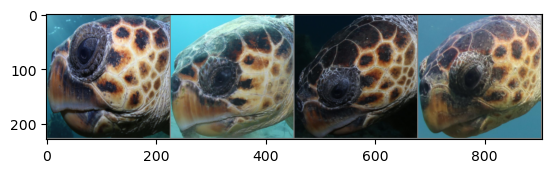

t243  t025  t243  t243 


In [8]:
# functions to show an image

from torchvision.io import read_image  

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)  
labels_tensor=torch.IntTensor([classes.index(i) for i in labels])



# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels_tensor[j]]:5s}' for j in range(batch_size)))

In [9]:
#Defining the convolutional neural network :https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [10]:
#Defing the loss function and optmiser :https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
#Training the network: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data 
        labels_tensor1=torch.LongTensor([classes.index(i) for i in labels])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels_tensor1)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [12]:
#Saving the trained model 
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


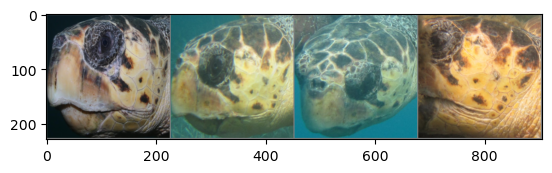

GroundTruth:  t023  t023  t023  t023 


In [13]:
#Testing the network on the test data 
dataiter = iter(testloader)
images, labels = next(dataiter) 
labels_tensor=torch.IntTensor([classes.index(i) for i in labels])

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels_tensor[j]]:5s}' for j in range(4)))

In [14]:
#Loading back to saved model 
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
#Seeing what the neural network thinks these images are 
outputs = net(images)

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  t023  t023  t204  t323 


In [20]:
#Results not good 
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data 
        labels_tensor=torch.IntTensor([classes.index(i) for i in labels])
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels_tensor.size(0)
        correct += (predicted == labels_tensor).sum().item()

print(f'Accuracy of the network on the 71 test images: {100 * correct // total} %') 
#24% accuracy- so it is not random.

Accuracy of the network on the 71 test images: 42 %


In [19]:
#Looking at the classes that performed well and which classes did not perform well 
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels_tensor=torch.IntTensor([classes.index(i) for i in labels])
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels_tensor, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: t023  is 50.0 %
Accuracy for class: t025  is 33.3 %
Accuracy for class: t033  is 14.3 %
Accuracy for class: t034  is 50.0 %
Accuracy for class: t073  is 20.0 %
Accuracy for class: t094  is 0.0 %
Accuracy for class: t204  is 71.4 %
Accuracy for class: t217  is 53.8 %
Accuracy for class: t243  is 35.7 %
Accuracy for class: t323  is 53.8 %
